In [51]:
from music21 import *
import glob
import numpy as np
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.callbacks import History, ModelCheckpoint
from keras.optimizers import RMSprop
from datetime import datetime

In [52]:
path = '/home/eurismar/notebooks/Music_Generator_Demo/Pop_Music_Midi/'
#path = '/home/eurismar/Downloads/midi/Harpa.Crista.em.Arquivo.MIDI'
#path = '/home/eurismar/notebooks/c-rnn-gan/datadir/classical/chopin'

In [53]:
files = glob.glob('{}/*.mid*'.format(path))

In [54]:
files

['/home/eurismar/notebooks/Music_Generator_Demo/Pop_Music_Midi/Blank Space - Verse.midi',
 '/home/eurismar/notebooks/Music_Generator_Demo/Pop_Music_Midi/Locked Out Of Heaven - Chorus.midi',
 '/home/eurismar/notebooks/Music_Generator_Demo/Pop_Music_Midi/Every Time We Touch - Verse.midi',
 '/home/eurismar/notebooks/Music_Generator_Demo/Pop_Music_Midi/Roar - Verse.midi',
 '/home/eurismar/notebooks/Music_Generator_Demo/Pop_Music_Midi/All The Small Things - Chorus.midi',
 '/home/eurismar/notebooks/Music_Generator_Demo/Pop_Music_Midi/Someone Like You - Chorus.midi',
 '/home/eurismar/notebooks/Music_Generator_Demo/Pop_Music_Midi/Hot N Cold - Chorus.midi',
 '/home/eurismar/notebooks/Music_Generator_Demo/Pop_Music_Midi/Love Me Harder ft The Weeknd - Chorus.midi',
 '/home/eurismar/notebooks/Music_Generator_Demo/Pop_Music_Midi/Beautiful Life - Chorus.midi',
 '/home/eurismar/notebooks/Music_Generator_Demo/Pop_Music_Midi/Girl On Fire - Verse.midi',
 '/home/eurismar/notebooks/Music_Generator_Demo/Po

In [55]:
file = files[0]

In [56]:
midi_stream = converter.parse(file)

In [57]:
part0 = midi_stream[0]

In [58]:
key_sig = part0.keySignature

In [59]:
print(key_sig)

C major


In [60]:
KEY_SIG_OFFSET = 0

In [61]:
midi_stream.transpose(KEY_SIG_OFFSET - key_sig.tonic.pitchClass, inPlace=True)

In [62]:
melody_corpus = []
for m in part0.measures(1, None):
    m.show('text')
    if hasattr(m, 'flat'):
        for nr in m.flat.notesAndRests:
            pitch = nr.pitch.midi  if isinstance(nr, note.Note) else 0
            duration = float(nr.quarterLength)
            note_repr = (pitch, duration)
            melody_corpus.append(note_repr)

{0.0} <music21.instrument.Instrument >
{0.0} <music21.clef.TrebleClef>
{0.0} <music21.tempo.MetronomeMark animato Quarter=120.0>
{0.0} <music21.key.Key of C major>
{0.0} <music21.meter.TimeSignature 4/4>
{0.0} <music21.note.Rest rest>
{1.0} <music21.note.Note C>
{1.25} <music21.note.Note C>
{1.5} <music21.note.Rest rest>
{2.0} <music21.note.Note C>
{2.25} <music21.note.Note C>
{2.5} <music21.note.Rest rest>
{3.0} <music21.note.Note C>
{3.25} <music21.note.Note C>
{3.5} <music21.note.Rest rest>
{0.0} <music21.note.Note C>
{1.0} <music21.note.Note E>
{1.25} <music21.note.Note E>
{1.75} <music21.note.Note E>
{2.25} <music21.note.Note D>
{2.75} <music21.note.Note C>
{3.0} <music21.note.Note D>
{3.25} <music21.note.Note C>
{3.5} <music21.note.Note D>
{0.0} <music21.note.Note A>
{0.5} <music21.note.Rest rest>
{1.0} <music21.note.Note C>
{1.25} <music21.note.Note C>
{1.5} <music21.note.Rest rest>
{2.0} <music21.note.Note C>
{2.25} <music21.note.Note C>
{2.5} <music21.note.Rest rest>
{3.0} <mu

In [63]:
melody_corpus

[(0, 1.0),
 (60, 0.25),
 (60, 0.25),
 (0, 0.5),
 (60, 0.25),
 (60, 0.25),
 (0, 0.5),
 (60, 0.25),
 (60, 0.25),
 (0, 0.5),
 (60, 1.0),
 (64, 0.25),
 (64, 0.5),
 (64, 0.5),
 (62, 0.5),
 (60, 0.25),
 (62, 0.25),
 (60, 0.25),
 (62, 0.5),
 (57, 0.5),
 (0, 0.5),
 (60, 0.25),
 (60, 0.25),
 (0, 0.5),
 (60, 0.25),
 (60, 0.25),
 (0, 0.5),
 (60, 0.25),
 (60, 0.25),
 (0, 0.5),
 (60, 1.0),
 (64, 0.25),
 (64, 0.5),
 (64, 0.75),
 (64, 0.25),
 (62, 0.5),
 (60, 0.5),
 (0, 0.25),
 (53, 0.5),
 (60, 0.5),
 (60, 0.5),
 (0, 0.5),
 (53, 0.25),
 (64, 0.25),
 (64, 0.25),
 (64, 1.0),
 (0, 0.25),
 (53, 0.5),
 (60, 0.5),
 (60, 0.5),
 (0, 0.25),
 (53, 0.25),
 (53, 0.25),
 (64, 0.25),
 (64, 0.25),
 (64, 1.0),
 (0, 0.25),
 (55, 0.5),
 (60, 0.5),
 (60, 0.5),
 (0, 0.5),
 (55, 0.25),
 (60, 0.25),
 (64, 1.0),
 (65, 0.25),
 (64, 0.25),
 (62, 2.0),
 (0, 0.5),
 (62, 0.5)]

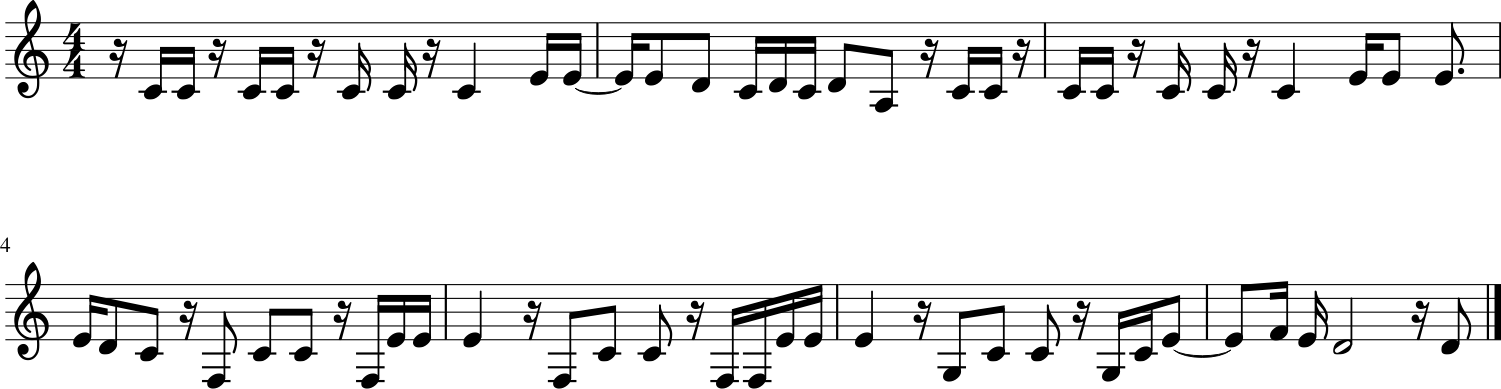

In [64]:
from music21 import *
sc = stream.Score()
for t in melody_corpus:
    if t[0] == 0.0:
        r = note.Rest(quarterLength = 0.25)
        sc.append(r)
    else:
        n = note.Note(midi=t[0], quarterLength=t[1])
        sc.append(n)
sc.show()

In [65]:
KEY_SIG_OFFSET = 0 
melody_corpus = []
for i, file in enumerate(files):
#for file in files:
    midi_stream = converter.parse(file)
    
    part0 = midi_stream[0]
    key_sig = part0.keySignature
    print(key_sig)
    print('----->',i)
    midi_stream.transpose(KEY_SIG_OFFSET - key_sig.tonic.pitchClass, inPlace=True)
    print(key_sig)
    for m in part0.measures(1, None):
        if hasattr(m, 'flat'):
            for nr in m.flat.notesAndRests:
                pitch = nr.pitch.midi  if isinstance(nr, note.Note) else 0
                duration = float(nr.quarterLength)
                note_repr = (pitch, duration)
                melody_corpus.append(note_repr)

C major
-----> 0
C major
C major
-----> 1
C major
C major
-----> 2
C major
C major
-----> 3
C major
C major
-----> 4
C major
C major
-----> 5
C major
C major
-----> 6
C major
C major
-----> 7
C major
C major
-----> 8
C major
C major
-----> 9
C major
C major
-----> 10
C major
C major
-----> 11
C major
C major
-----> 12
C major
C major
-----> 13
C major
C major
-----> 14
C major
C major
-----> 15
C major
C major
-----> 16
C major
C major
-----> 17
C major
C major
-----> 18
C major
C major
-----> 19
C major
C major
-----> 20
C major
C major
-----> 21
C major
C major
-----> 22
C major
C major
-----> 23
C major
C major
-----> 24
C major
C major
-----> 25
C major
C major
-----> 26
C major
C major
-----> 27
C major
C major
-----> 28
C major
C major
-----> 29
C major
C major
-----> 30
C major
C major
-----> 31
C major
C major
-----> 32
C major
C major
-----> 33
C major
C major
-----> 34
C major
C major
-----> 35
C major
C major
-----> 36
C major
C major
-----> 37
C major
C major
-----> 38
C ma

In [66]:
melody_set = set(melody_corpus)

In [67]:
notes_indices = {note: i for i, note in enumerate(melody_set)}
indices_notes = {i: note for i, note in enumerate(melody_set)}

In [68]:
corpus_size = len(melody_set)
print(corpus_size)

231


In [69]:
phrase_len = 20
step_size = 3

In [70]:
phrases = []
next_notes = []

In [71]:
for i in range(0, len(melody_corpus) - phrase_len, step_size):
    phrases.append(melody_corpus[i: i + phrase_len])
    next_notes.append(melody_corpus[i + phrase_len])
print('nb sequences:', len(phrases))

nb sequences: 2327


In [72]:
# transform data into binary matrices
X = np.zeros((len(phrases), phrase_len, corpus_size), dtype=np.bool)
y = np.zeros((len(phrases), corpus_size), dtype=np.bool)
print(X.shape)
print(y.shape)

(2327, 20, 231)
(2327, 231)


In [73]:
for i, phrase in enumerate(phrases):
    for j, note in enumerate(phrase):
        X[i, j, notes_indices[note]] = 1
    y[i, notes_indices[next_notes[i]]] = 1

In [155]:
layer_size=128
batch_size = 128
nb_epoch = 400

In [156]:
model = Sequential()
model.add(LSTM(layer_size, return_sequences=True, input_shape=(phrase_len, corpus_size)))
model.add(Dropout(0.2))
model.add(LSTM(layer_size, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(corpus_size))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [157]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 20, 128)           184320    
_________________________________________________________________
dropout_7 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 231)               29799     
_________________________________________________________________
activation_4 (Activation)    (None, 231)               0         
Total params: 345,703
Trainable params: 345,703
Non-trainable params: 0
_________________________________________________________________


In [158]:
history = History()

In [159]:
model.fit(X, y, batch_size=batch_size, epochs=nb_epoch, callbacks=[history])

Epoch 1/400
2327/2327 [==============================] - 1s - loss: 4.6401 - acc: 0.0602     
Epoch 2/400
2327/2327 [==============================] - 1s - loss: 4.1649 - acc: 0.0713     
Epoch 3/400
2327/2327 [==============================] - 1s - loss: 4.0426 - acc: 0.0778     
Epoch 4/400
2327/2327 [==============================] - 1s - loss: 3.9736 - acc: 0.0859     
Epoch 5/400
2327/2327 [==============================] - 1s - loss: 3.9230 - acc: 0.0928     
Epoch 6/400
2327/2327 [==============================] - 1s - loss: 3.8677 - acc: 0.0907     
Epoch 7/400
2327/2327 [==============================] - 1s - loss: 3.8360 - acc: 0.0928     
Epoch 8/400
2327/2327 [==============================] - 1s - loss: 3.8064 - acc: 0.0885     
Epoch 9/400
2327/2327 [==============================] - 1s - loss: 3.7753 - acc: 0.0958     
Epoch 10/400
2327/2327 [==============================] - 1s - loss: 3.7306 - acc: 0.0997     
Epoch 11/400
2327/2327 [==============================] - 1

2327/2327 [==============================] - 1s - loss: 1.5069 - acc: 0.5630     
Epoch 88/400
2327/2327 [==============================] - 1s - loss: 1.4676 - acc: 0.5840     
Epoch 89/400
2327/2327 [==============================] - 1s - loss: 1.4739 - acc: 0.5707     
Epoch 90/400
2327/2327 [==============================] - 1s - loss: 1.4389 - acc: 0.5870     
Epoch 91/400
2327/2327 [==============================] - 1s - loss: 1.3991 - acc: 0.6008     
Epoch 92/400
2327/2327 [==============================] - 1s - loss: 1.3861 - acc: 0.6081     
Epoch 93/400
2327/2327 [==============================] - 1s - loss: 1.3663 - acc: 0.6059     
Epoch 94/400
2327/2327 [==============================] - 1s - loss: 1.3319 - acc: 0.6197     
Epoch 95/400
2327/2327 [==============================] - 1s - loss: 1.3139 - acc: 0.6235     
Epoch 96/400
2327/2327 [==============================] - 1s - loss: 1.2827 - acc: 0.6261     
Epoch 97/400
2327/2327 [==============================] - 1s - 

2327/2327 [==============================] - 1s - loss: 0.3213 - acc: 0.9145     
Epoch 173/400
2327/2327 [==============================] - 1s - loss: 0.2911 - acc: 0.9308     
Epoch 174/400
2327/2327 [==============================] - 1s - loss: 0.3249 - acc: 0.9158     
Epoch 175/400
2327/2327 [==============================] - 1s - loss: 0.2940 - acc: 0.9278     
Epoch 176/400
2327/2327 [==============================] - 1s - loss: 0.2892 - acc: 0.9364     
Epoch 177/400
2327/2327 [==============================] - 1s - loss: 0.3069 - acc: 0.9175     
Epoch 178/400
2327/2327 [==============================] - 1s - loss: 0.2828 - acc: 0.9265     
Epoch 179/400
2327/2327 [==============================] - 1s - loss: 0.3002 - acc: 0.9261     
Epoch 180/400
2327/2327 [==============================] - 1s - loss: 0.3143 - acc: 0.9136     
Epoch 181/400
2327/2327 [==============================] - 1s - loss: 0.2628 - acc: 0.9403     
Epoch 182/400
2327/2327 [=============================

2327/2327 [==============================] - 1s - loss: 0.1415 - acc: 0.9661     
Epoch 258/400
2327/2327 [==============================] - 1s - loss: 0.1358 - acc: 0.9665     
Epoch 259/400
2327/2327 [==============================] - 1s - loss: 0.1342 - acc: 0.9661     
Epoch 260/400
2327/2327 [==============================] - 1s - loss: 0.1177 - acc: 0.9682     
Epoch 261/400
2327/2327 [==============================] - 1s - loss: 0.1123 - acc: 0.9729     
Epoch 262/400
2327/2327 [==============================] - 1s - loss: 0.1198 - acc: 0.9708     
Epoch 263/400
2327/2327 [==============================] - 1s - loss: 0.1261 - acc: 0.9643     
Epoch 264/400
2327/2327 [==============================] - 1s - loss: 0.1191 - acc: 0.9686     
Epoch 265/400
2327/2327 [==============================] - 1s - loss: 0.1286 - acc: 0.9678     
Epoch 266/400
2327/2327 [==============================] - 1s - loss: 0.1077 - acc: 0.9686     
Epoch 267/400
2327/2327 [=============================

2327/2327 [==============================] - 1s - loss: 0.0800 - acc: 0.9820     
Epoch 343/400
2327/2327 [==============================] - 1s - loss: 0.0560 - acc: 0.9862     
Epoch 344/400
2327/2327 [==============================] - 1s - loss: 0.0791 - acc: 0.9794     
Epoch 345/400
2327/2327 [==============================] - 1s - loss: 0.0770 - acc: 0.9811     
Epoch 346/400
2327/2327 [==============================] - 1s - loss: 0.0721 - acc: 0.9807     
Epoch 347/400
2327/2327 [==============================] - 1s - loss: 0.0923 - acc: 0.9738     
Epoch 348/400
2327/2327 [==============================] - 1s - loss: 0.0676 - acc: 0.9824     
Epoch 349/400
2327/2327 [==============================] - 1s - loss: 0.0611 - acc: 0.9858     
Epoch 350/400
2327/2327 [==============================] - 1s - loss: 0.0784 - acc: 0.9794     
Epoch 351/400
2327/2327 [==============================] - 1s - loss: 0.0656 - acc: 0.9832     
Epoch 352/400
2327/2327 [=============================

In [160]:
import matplotlib.pyplot as plt

dict_keys(['loss', 'acc'])


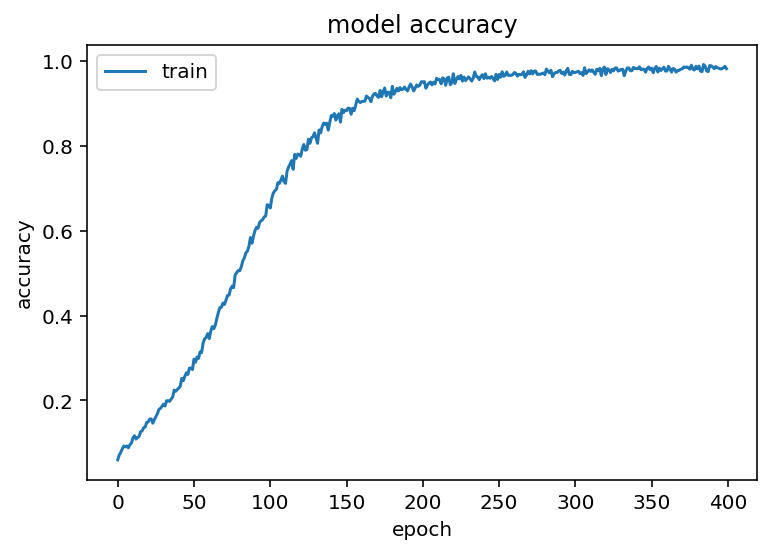

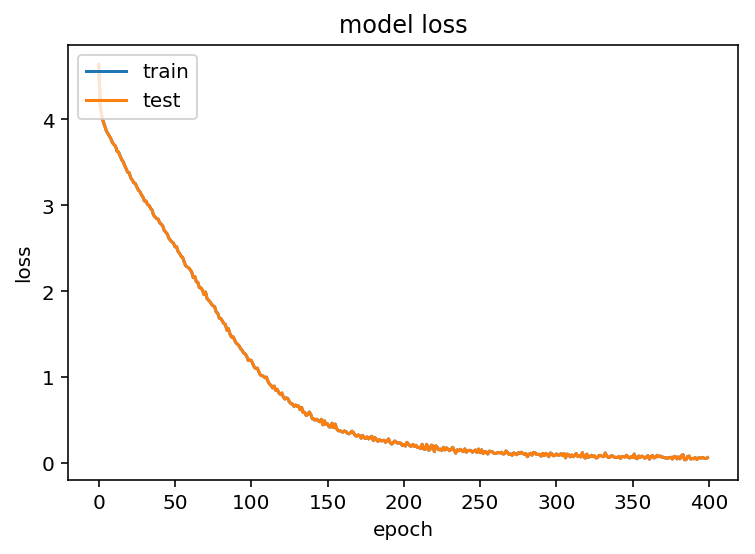

In [161]:

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [162]:
gen_melody_indices = np.zeros((1, phrase_len, len(melody_set)))
print(gen_melody_indices.shape)

(1, 20, 231)


In [163]:
start_pos = np.random.randint(0, len(melody_corpus) - phrase_len)

In [164]:
seed_phrase = melody_corpus[start_pos : start_pos + phrase_len]

In [165]:
gen_melody = seed_phrase

In [166]:
seq_len = 100

In [167]:
start = np.random.randint(0, len(phrases)-1)
pattern = phrases[start]
#print('pattern original:')
#print(pattern)
nova_sequencia = []
for i in range(seq_len):
    gen_melody_indices = np.zeros((1, phrase_len, len(melody_set)))
    for j, note in enumerate(pattern):
        gen_melody_indices[0, j, notes_indices[note]] = 1
    x = gen_melody_indices
    prediction = model.predict(x, verbose=0)[0]
    index = np.argmax(prediction)
    result = indices_notes[index]
    #print('result:',result)
    nova_sequencia.append(result)
    pattern.append(result)
    pattern = pattern[1:len(pattern)]
    #print('pattern {}:'.format(i))
    #print(pattern)

In [168]:
nova_sequencia

[(67, 1.0),
 (67, 1.0),
 (64, 0.5),
 (64, 0.5),
 (64, 0.5),
 (69, 0.5),
 (69, 0.5),
 (69, 0.5),
 (64, 0.5),
 (62, 1.0),
 (64, 1.0),
 (64, 1.0),
 (64, 1.0),
 (64, 1.0),
 (64, 1.0),
 (64, 1.0),
 (57, 1.0),
 (57, 1.0),
 (57, 1.0),
 (57, 1.0),
 (62, 0.5),
 (64, 2.0),
 (60, 0.75),
 (60, 0.75),
 (57, 0.5),
 (57, 0.5),
 (57, 0.5),
 (64, 0.5),
 (67, 1.0),
 (67, 1.0),
 (67, 1.0),
 (64, 0.5),
 (64, 0.5),
 (65, 1.0),
 (59, 0.25),
 (59, 0.25),
 (62, 2.5),
 (62, 2.5),
 (57, 0.5),
 (57, 0.5),
 (65, 1.0),
 (57, 0.5),
 (65, 1.0),
 (65, 0.5),
 (60, 0.5),
 (64, 0.5),
 (57, 0.5),
 (62, 0.5),
 (64, 4.0),
 (60, 0.5),
 (53, 0.5),
 (53, 0.5),
 (53, 0.5),
 (64, 0.5),
 (53, 0.5),
 (53, 0.5),
 (53, 0.5),
 (53, 0.5),
 (60, 0.5),
 (65, 0.5),
 (65, 0.5),
 (57, 0.5),
 (60, 0.5),
 (55, 1.0),
 (60, 0.5),
 (55, 1.0),
 (60, 0.5),
 (60, 0.5),
 (60, 0.5),
 (60, 0.5),
 (60, 0.5),
 (60, 0.5),
 (48, 0.5),
 (60, 1.0),
 (57, 0.5),
 (57, 0.5),
 (57, 0.5),
 (57, 0.5),
 (60, 0.5),
 (60, 0.5),
 (60, 0.5),
 (60, 0.5),
 (62, 0.25),

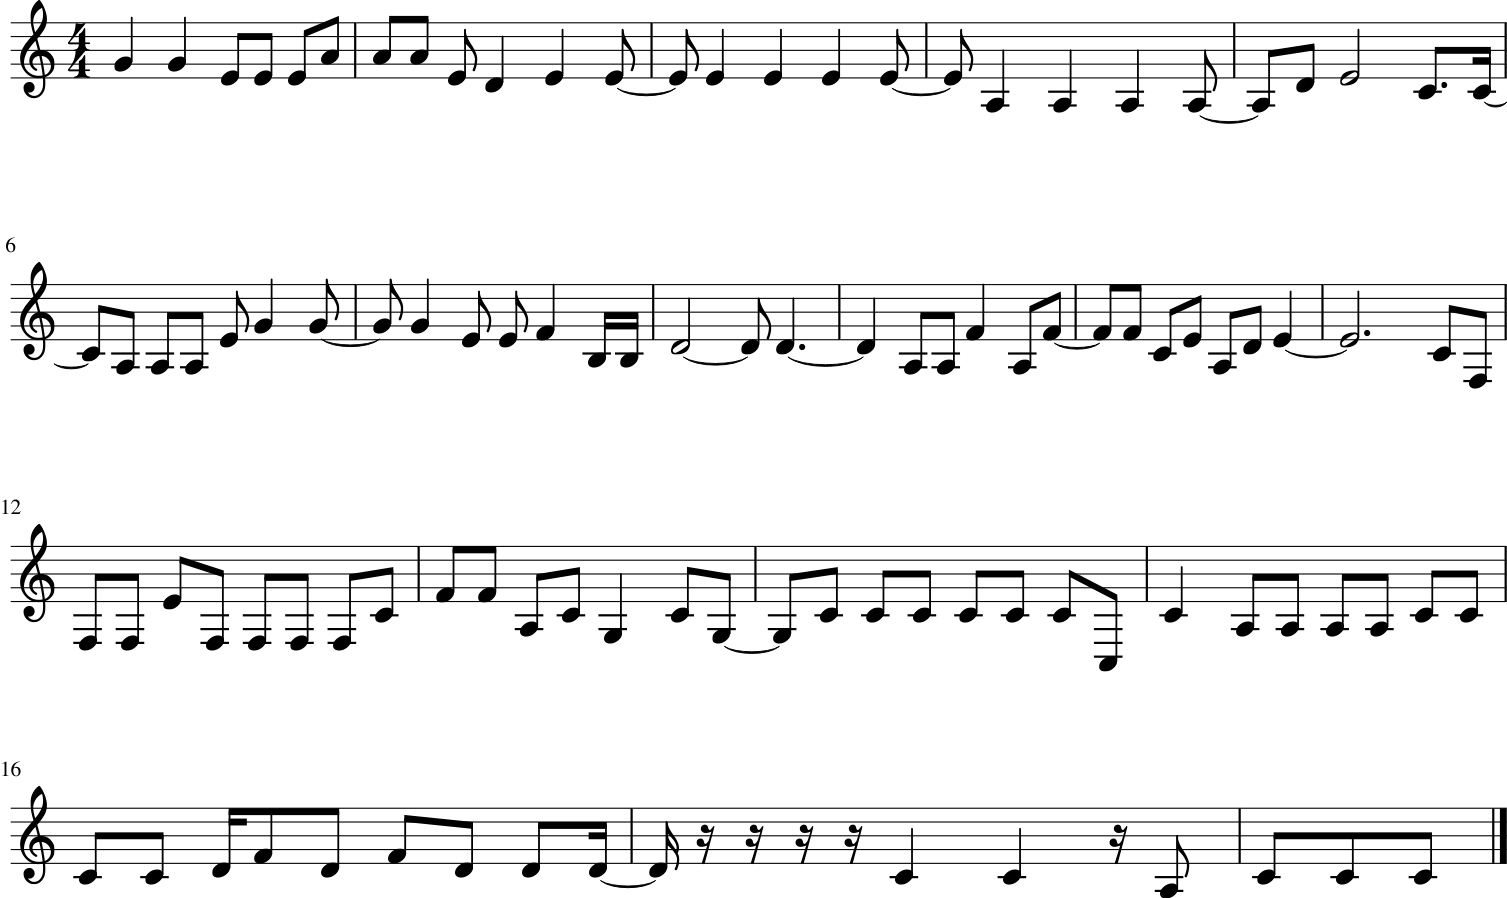

In [169]:
from music21 import *
sc = stream.Score()
for t in nova_sequencia:
    if t[0] == 0.0:
        r = note.Rest(quarterLength = 0.25)
        sc.append(r)
    else:
        n = note.Note(midi=t[0], quarterLength=t[1])
        sc.append(n)
sc.show()

In [170]:
filename = "gerada_" + datetime.now().strftime("%Y%m%d-%H%M%S"+".mid")

In [171]:
print(filename)

gerada_20180629-213253.mid


In [172]:
from music21 import *
mf = midi.translate.streamToMidiFile(sc)
mf.open(filename, 'wb')
mf.write()
mf.close()

In [173]:
!pwd

/home/eurismar/notebooks/JohaNN
